## Bayesian Tomatoes

Casablanca | Jaws
---------- | ----
![casablanca](hw3_img/casablanca.jpg) |![jaws](hw3_img/jaws.jpg)

In this assignment, you'll be analyzing movie reviews from [Rotten Tomatoes](http://www.rottentomatoes.com). This assignment will cover:

 * Working with web APIs
 * Making and interpreting predictions from a Bayesian perspective
 * Using the Naive Bayes algorithm to predict whether a movie review is positive or negative
 * Using cross validation to optimize models

In [1]:
import pandas as pd
import numpy as np

"""   
helper python script that contains all functions 
referenced in this ipynb.
"""
%run hw3.py

### Introduction

`Rotten Tomatoes` gathers movie reviews from critics. An entry on the website typically consists of a short quote, a link to the full review, and a Fresh/Rotten classification which summarizes whether the critic liked/disliked the movie.

When critics give quantitative ratings (say 3/4 stars, Thumbs up, etc.), determining the Fresh/Rotten classification is easy. However, publications like the New York Times don't assign numerical ratings to movies, and thus the Fresh/Rotten classification must be inferred from the text of the review itself.

This basic task of categorizing text has many applications. All of the following questions boil down to text classification:

    Is a movie review positive or negative?
    Is an email spam, or not?
    Is a comment on a blog discussion board appropriate, or not?
    Is a tweet about your company positive, or not?

Language is incredibly nuanced, and there is an entire field of computer science dedicated to the topic (Natural Language Processing). Nevertheless, we can construct basic language models using fairly straightforward techniques.

### The Data


In [2]:
from pandas.compat import StringIO

movies = pd.read_csv('../data/movies.dat', delimiter='\t')
movies.head()

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
0,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,...,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...
1,2,Jumanji,113497,Jumanji,http://ia.media-imdb.com/images/M/MV5BMzM5NjE1...,1995,1068044-jumanji,5.6,28,13,...,46,5.8,5,2,3,40,3.2,44587,61,http://content8.flixster.com/movie/56/79/73/56...
2,3,Grumpy Old Men,107050,Dos viejos gruñones,http://ia.media-imdb.com/images/M/MV5BMTI5MTgy...,1993,grumpy_old_men,5.9,36,24,...,66,7,6,5,1,83,3.2,10489,66,http://content6.flixster.com/movie/25/60/25602...
3,4,Waiting to Exhale,114885,Esperando un respiro,http://ia.media-imdb.com/images/M/MV5BMTczMTMy...,1995,waiting_to_exhale,5.6,25,14,...,56,5.5,11,5,6,45,3.3,5666,79,http://content9.flixster.com/movie/10/94/17/10...
4,5,Father of the Bride Part II,113041,Vuelve el padre de la novia (Ahora también abu...,http://ia.media-imdb.com/images/M/MV5BMTg1NDc2...,1995,father_of_the_bride_part_ii,5.3,19,9,...,47,5.4,5,1,4,20,3,13761,64,http://content8.flixster.com/movie/25/54/25542...


In [2]:
critics = pd.read_csv('../data/critics.csv')
critics.head()

,critic,date,fresh,imdb,original_score,publication,quote,review_date,rt_id,title
0,Derek Adams,2009-10-04,fresh,114709,5/5,Time Out,"So ingenious in concept, design and execution ...",http://www.timeout.com/film/reviews/87745/toy-...,9559,Toy Story
1,Richard Corliss,2008-08-31,fresh,114709,NaN,TIME Magazine,The year's most inventive comedy.,"http://www.time.com/time/magazine/article/0,91...",9559,Toy Story
2,David Ansen,2008-08-18,fresh,114709,NaN,Newsweek,A winning animated feature that has something ...,http://www.newsweek.com/id/104199,9559,Toy Story
3,Leonard Klady,2008-06-09,fresh,114709,NaN,Variety,The film sports a provocative and appealing st...,http://www.variety.com/review/VE1117941294.htm...,9559,Toy Story
4,Jonathan Rosenbaum,2008-03-10,fresh,114709,NaN,Chicago Reader,"An entertaining computer-generated, hyperreali...",http://onfilm.chicagoreader.com/movies/capsule...,9559,Toy Story


### Exploration

In [17]:
# How many reviews, critics, and movies are in this dataset?
n_reviews = len(critics)
n_movies = critics.rt_id.unique().size
n_critics = critics.critic.unique().size

print("Number of reviews: {}".format(n_reviews))
print("Number of critics: {}".format(n_critics))
print("Number of movies:  {}".format(n_movies))

Number of reviews: 15610
Number of critics: 622
Number of movies:  1931


#### What does the distribution of number of reviews per reviewer look like?

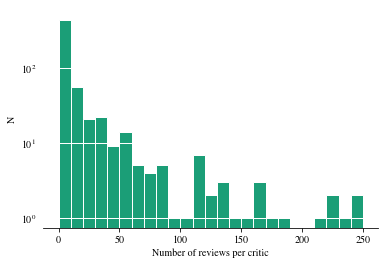

In [44]:
# after inspecting the data, remove top10 reviewers as outliers
def histogram_style():
    remove_border(left=False)
    plt.grid(False)
    plt.grid(axis='y', color='w', linestyle='-', lw=1)

critics.groupby('critic').rt_id.count().hist(log=True, bins=25, 
                                             ec='white', range=(0,250))

plt.xlabel("Number of reviews per critic")
plt.ylabel("N")
histogram_style()

#### List the 5 critics with the most reviews, along with the publication they write for

In [33]:
critics.groupby(['critic', 'publication']
               ).rt_id.count(
).sort_values(ascending=False).head(5)

critic              publication      
Roger Ebert         Chicago Sun-Times    1078
James Berardinelli  ReelViews             806
Janet Maslin        New York Times        519
Variety Staff       Variety               434
Jonathan Rosenbaum  Chicago Reader        414
Name: rt_id, dtype: int64